In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-04-25 13:42:30.876420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 13:42:30.876533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 13:42:31.001639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [9]:
filelist_trainx_ph2 = sorted(glob.glob('/kaggle/input/resized-segnet/resized_5000/trainx/*.jpg'), key=numericalSort)
X_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainx_ph2])

filelist_trainy_ph2 = sorted(glob.glob('/kaggle/input/resized-segnet/resized_5000/trainy/*.png'), key=numericalSort)
Y_train_ph2 = np.array([np.array(Image.open(fname)) for fname in filelist_trainy_ph2])

In [10]:
print("Size of X_train_ph2:", X_train_ph2.shape)
print("Size of Y_train_ph2:", Y_train_ph2.shape)

Size of X_train_ph2: (5000, 192, 256, 3)
Size of Y_train_ph2: (5000, 192, 256)


In [ ]:
def resize(filename, size = (256,192)):
    im = Image.open(filename)
    im_resized = im.resize(size, Image.ANTIALIAS)
    return (im_resized)
#   im_resized.save('/resized_ph2/X_train/X_img_'+str(i)+'.bmp', dpi = (192,256))

In [ ]:
X_train_ph2_resized = []
Y_train_ph2_resized = []

for i in range(len(filelist_trainx_ph2)):
    X_train_ph2_resized.append(resize(filelist_trainx_ph2[i]))
    Y_train_ph2_resized.append(resize(filelist_trainy_ph2[i]))

In [ ]:
X_train_ph2 = np.array([np.array(img) for img in X_train_ph2_resized])
Y_train_ph2 = np.array([np.array(img) for img in Y_train_ph2_resized])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_train_ph2, Y_train_ph2, test_size = 0.25, random_state = 101)

In [12]:
def iou(y_true, y_pred, smooth = 100):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [17]:
def dice_coef(y_true, y_pred, smooth = 100):
     
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, dtype='float32')
    y_pred_f = K.cast(y_pred_f, dtype='float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [14]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [15]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [23]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 101)

In [14]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 3000
Length of the Test Set       : 1250
Length of the Validation Set : 750


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall, Accuracy
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred, axis=(1,2))
    denominator = K.sum(y_true + y_pred, axis=(1,2))
    return 1 - K.mean(numerator / (denominator + K.epsilon()))

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Conv2DTranspose, BatchNormalization, Activation, Dense, Reshape

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, Accuracy

def segnet_transfer_learning(weights_path, epochs_num, savename):

    # Encoding layer
    img_input = Input(shape= (192, 256, 3))

    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)

    model = Model(inputs=img_input, outputs=pred)

    model.load_weights(weights_path)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.9), loss=["binary_crossentropy"],
              metrics=[iou, dice_coef, Precision(), Recall(), accuracy])
    model.summary()
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    hist = model.fit(x_train, y_train, epochs=epochs_num, batch_size=18, 
                     validation_data=(x_val, y_val), verbose=1,
                     callbacks=callbacks_list)

    model.save('/kaggle/working/' + savename)
    return model,hist

In [21]:
# Example usage
weights_path = '/kaggle/input/segnet_ph2/tensorflow2/transfer_segnet_100/1/transfer_segnet_100_epo.keras'  # Path to the pre-trained weights
epochs_num = 1  # Number of epochs for fine-tuning
savename = 'retrain_segnet_1_ep.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

2024-04-25 10:28:45.739225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 2.23176, expected 1.27425
2024-04-25 10:28:45.739279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 4.15262, expected 3.19511
2024-04-25 10:28:45.739288: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 4.28259, expected 3.32508
2024-04-25 10:28:45.739296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 4.84574, expected 3.88822
2024-04-25 10:28:45.739303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 4.56285, expected 3.60534
2024-04-25 10:28:45.739311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 3.73815, expected 2.78063
2024-04-25 10:28:45.739318: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 4.70149, expected 3.74397
2024-04-25 10:28:45.739325:

133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6398 - dice_coef: 1.6953 - iou: 0.3234 - loss: -267.4301 - precision: 1.0255 - recall: 0.9909

2024-04-25 10:30:05.212882: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.09053, expected 1.58202
2024-04-25 10:30:05.212953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 3.41636, expected 2.90785
2024-04-25 10:30:05.212970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 4.00651, expected 3.498
2024-04-25 10:30:05.212988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.10563, expected 2.59712
2024-04-25 10:30:05.212999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 33: 3.62158, expected 3.11307
2024-04-25 10:30:05.213009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 74: 3.9719, expected 3.4634
2024-04-25 10:30:05.213021: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 135: 4.07418, expected 3.56568
2024-04-25 10:30:05.213032: E external/local_xla/xla

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.6398 - dice_coef: 1.6953 - iou: 0.3234 - loss: -267.4515 - precision: 1.0254 - recall: 0.9909
Epoch 1: val_loss improved from inf to -267.03281, saving model to retrain_segnet_1_ep.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 132s 532ms/step - accuracy: 0.6397 - dice_coef: 1.6953 - iou: 0.3234 - loss: -267.4726 - precision: 1.0253 - recall: 0.9910 - val_accuracy: 0.6352 - val_dice_coef: 1.6077 - val_iou: 0.3255 - val_loss: -267.0328 - val_precision: 1.1061 - val_recall: 0.9866


In [ ]:
# Example usage
weights_path = '/kaggle/input/segnet_ph2/tensorflow2/segent_100_keras/1/segnet_100_epoch.keras'  # Path to the pre-trained weights
epochs_num = 50  # Number of epochs for fine-tuning
savename = 'path_to_save_trained_models.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

In [22]:
# Example usage
weights_path = '/kaggle/working/retrain_segnet_1_ep.keras'  # Path to the pre-trained weights
epochs_num = 99  # Number of epochs for fine-tuning
savename = 'retrain_segnet_100_ep.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

Epoch 1/99
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6422 - dice_coef: 1.7516 - iou: 0.3232 - loss: -287.0718 - precision: 1.0165 - recall: 0.9926
Epoch 1: val_loss improved from inf to -231.30864, saving model to retrain_segnet_100_ep.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.6422 - dice_coef: 1.7516 - iou: 0.3232 - loss: -287.0600 - precision: 1.0165 - recall: 0.9926 - val_accuracy: 0.6152 - val_dice_coef: 1.6325 - val_iou: 0.3170 - val_loss: -231.3086 - val_precision: 1.0112 - val_recall: 0.9917
Epoch 2/99
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6508 - dice_coef: 1.7926 - iou: 0.3280 - loss: -297.9735 - precision: 1.0016 - recall: 0.9928
Epoch 2: val_loss improved from -231.30864 to -237.31787, saving model to retrain_segnet_100_ep.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.6507 - dice_coef: 1.7925 - iou: 0.3280 - loss: -297.9569 - precision: 1.0017 - recall: 0.9928 - val_accuracy: 0.6325 - val_dice_coef: 1.6

In [37]:
# Example usage
weights_path = '/kaggle/input/notebook7c53db0e77/retrain_segnet_100_ep.keras'  # Path to the pre-trained weights
epochs_num = 50  # Number of epochs for fine-tuning
savename = 'retrain_segnet_150_ep.keras'  # Path to save the trained model

# Call the function
model, history = segnet_transfer_learning(weights_path, epochs_num, savename)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 192, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 192, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_104 (Activation)     │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 192, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 192, 256, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 192, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 96, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 96, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_106 (Activation)     │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 96, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 96, 128, 128)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_107 (Activation)     │ (None, 96, 128, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 48, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 48, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_108 (Activation)     │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_109 (Activation)     │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 48, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn7 (BatchNormalization)        │ (None, 48, 64, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_110 (Activation)     │ (None, 48, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 24, 32, 256)    │             

 Total params: 33,393,669 (127.39 MB)

 Trainable params: 33,377,795 (127.33 MB)

 Non-trainable params: 15,874 (62.01 KB)

Epoch 1/50


W0000 00:00:1714053806.595615     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6603 - dice_coef: 1.8894 - iou: 0.3198 - loss: -560.7679 - precision_4: 0.9450 - recall_4: 0.9233

W0000 00:00:1714053863.425654     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to -444.43167, saving model to retrain_segnet_150_ep.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 95s 400ms/step - accuracy: 0.6602 - dice_coef: 1.8895 - iou: 0.3198 - loss: -560.7730 - precision_4: 0.9450 - recall_4: 0.9234 - val_accuracy: 0.6186 - val_dice_coef: 1.6550 - val_iou: 0.3134 - val_loss: -444.4317 - val_precision_4: 0.7994 - val_recall_4: 0.7858
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6698 - dice_coef: 1.9296 - iou: 0.3209 - loss: -570.4186 - precision_4: 0.9515 - recall_4: 0.9483
Epoch 2: val_loss did not improve from -444.43167
167/167 ━━━━━━━━━━━━━━━━━━━━ 49s 296ms/step - accuracy: 0.6697 - dice_coef: 1.9295 - iou: 0.3209 - loss: -570.4239 - precision_4: 0.9514 - recall_4: 0.9483 - val_accuracy: 0.5993 - val_dice_coef: 1.6361 - val_iou: 0.2936 - val_loss: -403.5787 - val_precision_4: 0.7523 - val_recall_4: 0.7807
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6618 - dice_coef: 1.9339 - iou: 0.31

In [39]:
# Encoding layer
img_input = Input(shape= (192, 256, 3))
x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
x = BatchNormalization(name='bn9')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
x = BatchNormalization(name='bn10')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
x = BatchNormalization(name='bn11')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
x = BatchNormalization(name='bn12')(x)
x = Activation('relu')(x)
x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
x = BatchNormalization(name='bn13')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)
# Decoding Layer
x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn14')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn15')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn16')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn17')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
x = BatchNormalization(name='bn18')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
x = BatchNormalization(name='bn19')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
x = BatchNormalization(name='bn20')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
x = BatchNormalization(name='bn21')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
x = BatchNormalization(name='bn22')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
x = BatchNormalization(name='bn23')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
x = BatchNormalization(name='bn24')(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
x = BatchNormalization(name='bn25')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
x = BatchNormalization(name='bn26')(x)
x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)


In [41]:
from tensorflow.keras.optimizers import SGD
model_1 = Model(inputs=img_input, outputs=pred)
model_1.compile(optimizer= SGD(learning_rate=0.001, momentum=0.9, decay=0.0005, nesterov=False), loss=["binary_crossentropy"] ,
               metrics=[iou, dice_coef, Precision(), Recall(), accuracy])


In [42]:
model_1.load_weights('/kaggle/working/retrain_segnet_150_ep.keras')

In [43]:
print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.6818 - dice_coef: 1.9847 - iou: 0.3217 - loss: -735.7407 - precision_6: 0.9920 - recall_6: 0.9728
________________________
IOU:       |   31.58  |
Dice Coef: |   198.49  |
Precision: |   99.21  |
Recall:    |   97.34  |
Accuracy:  |   67.61  |
Loss:      |   -74997.41  |
________________________

-------------On Test  Set--------------------------

70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.6200 - dice_coef: 1.5728 - iou: 0.2908 - loss: -524.7498 - precision_6: 0.8429 - recall_6: 0.7221


W0000 00:00:1714056745.045456     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


________________________
IOU:       |   29.88  |
Dice Coef: |   160.27  |
Precision: |   84.60  |
Recall:    |   74.16  |
Accuracy:  |   63.23  |
Loss:      |   -52605.73  |
________________________

-------------On validation Set---------------------

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6473 - dice_coef: 1.6374 - iou: 0.3208 - loss: -536.7690 - precision_6: 0.8727 - recall_6: 0.7646
________________________
IOU:       |   31.45  |
Dice Coef: |   162.52  |
Precision: |   86.32  |
Recall:    |   75.46  |
Accuracy:  |   64.31  |
Loss:      |   -53172.40  |
________________________


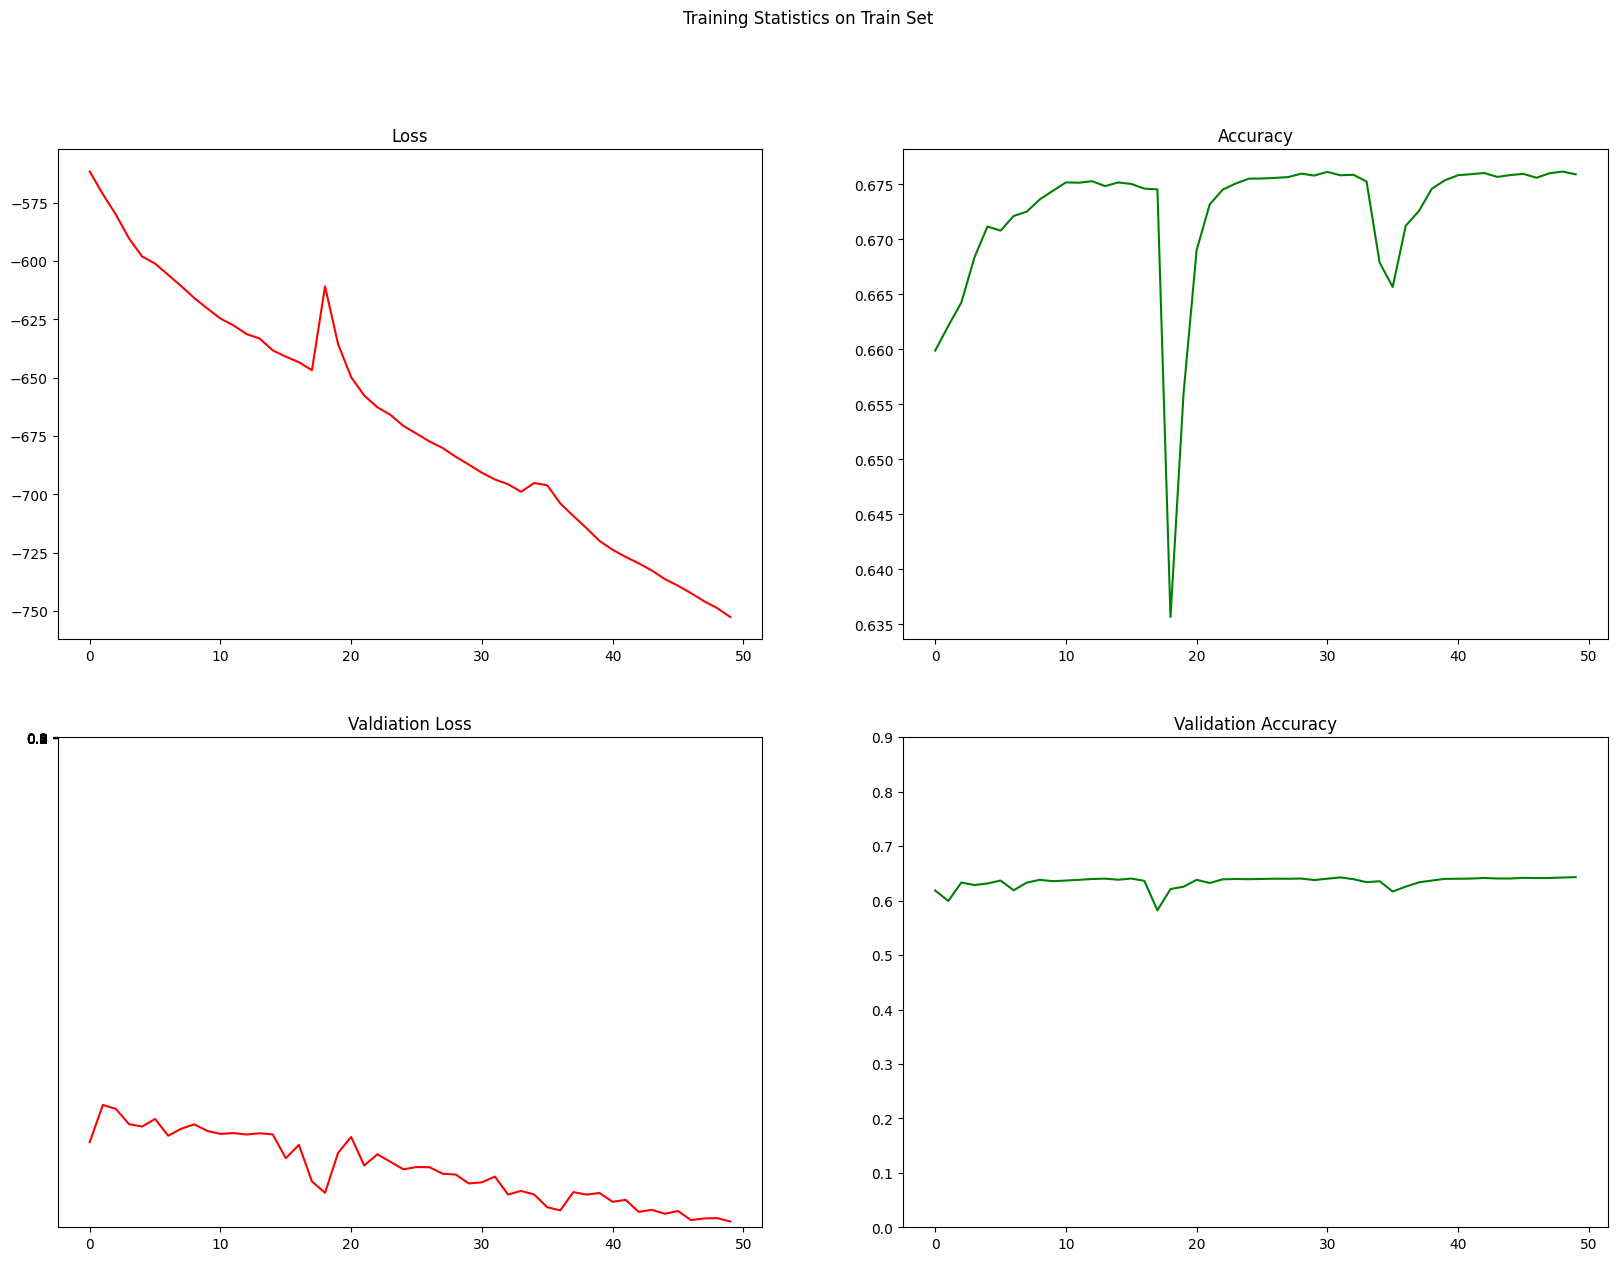

In [44]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(history.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(history.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(history.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


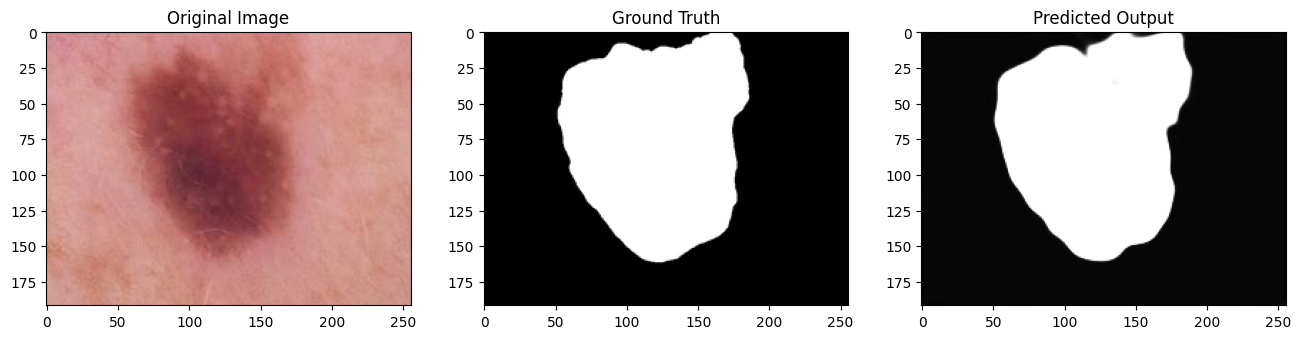

In [45]:
img_num = 49
img_pred = model.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


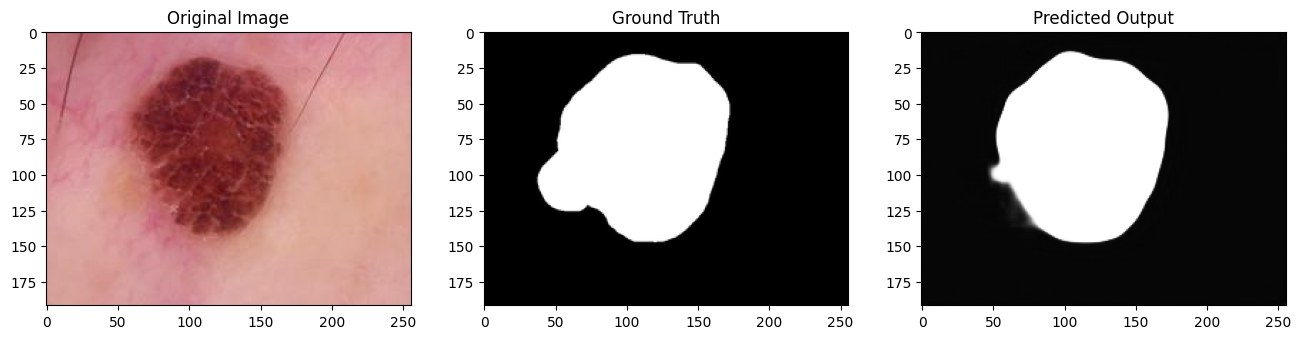

In [46]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


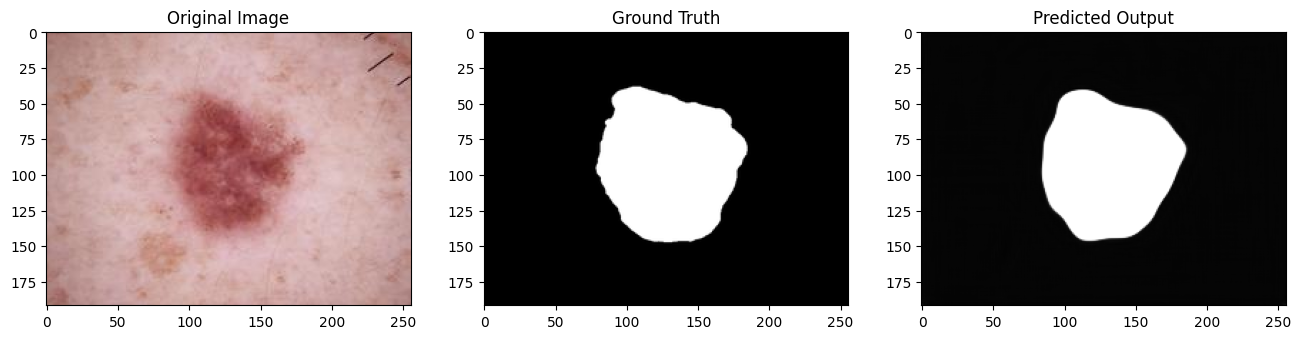

In [47]:
img_num = 320
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


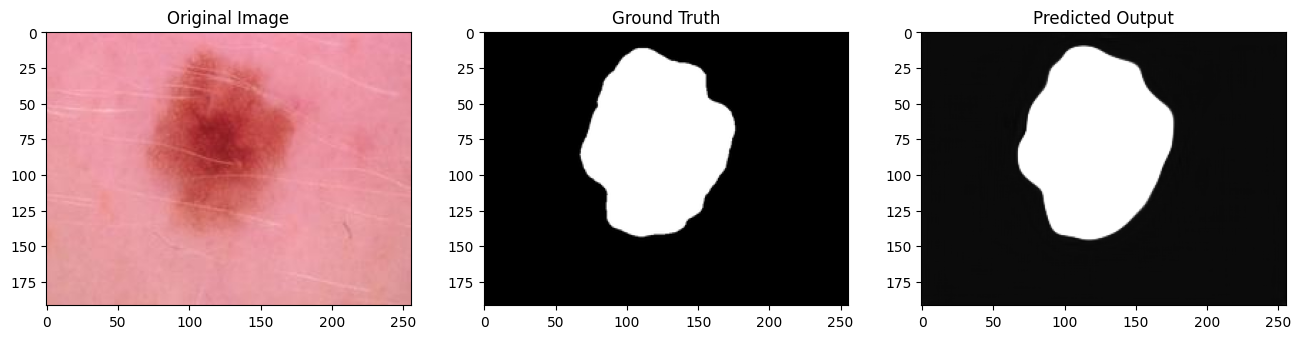

In [48]:
img_num = 455
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


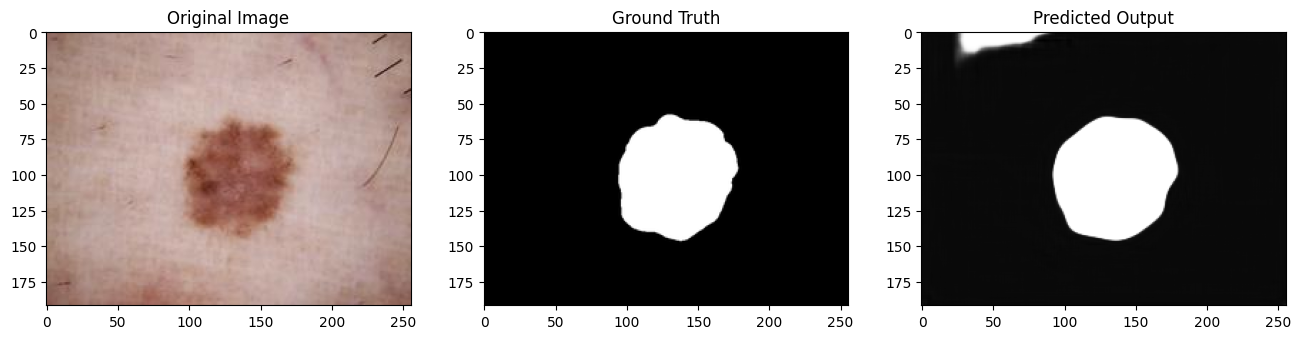

In [49]:
img_num = 210
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


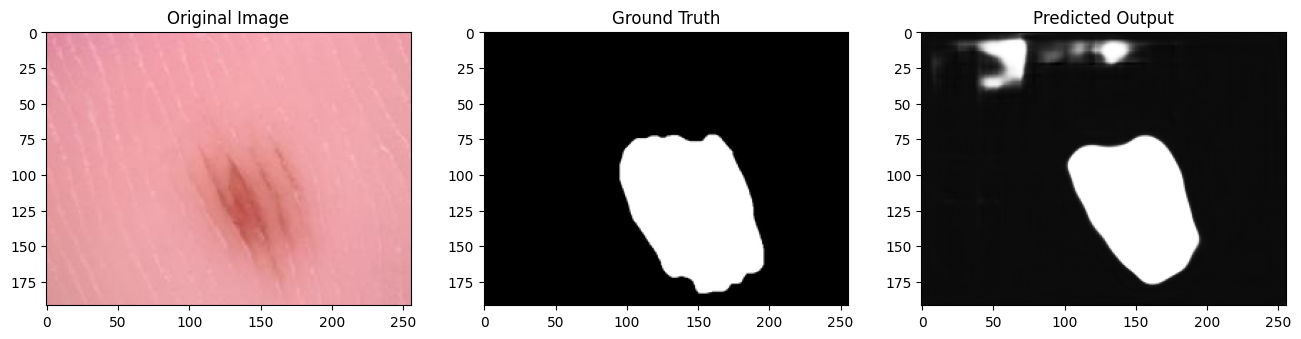

In [50]:
img_num = 497
img_pred = model_1.predict(x_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [51]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,192,256,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.2:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


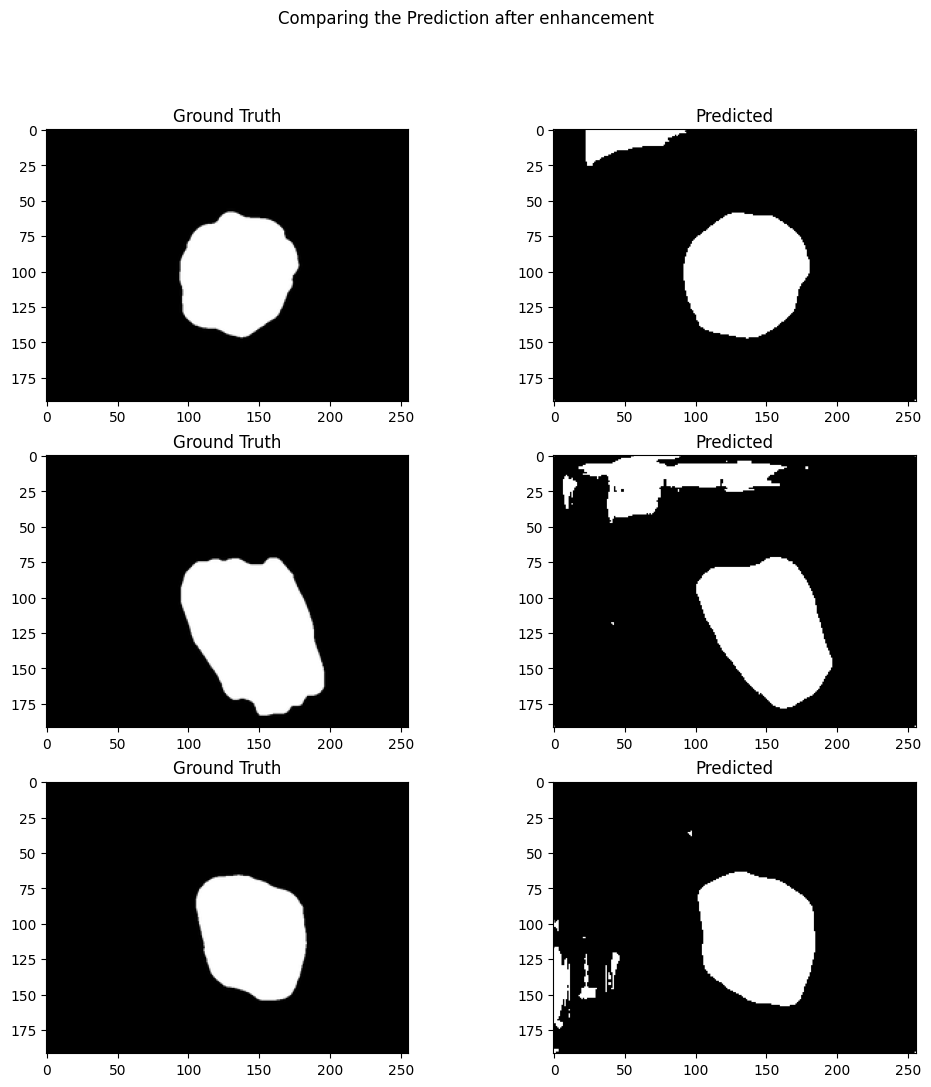

In [52]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[210],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[210]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[497],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[497]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[360],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[360]).reshape(192,256), plt.cm.binary_r)
plt.title('Predicted')
plt.show()